## Library Import

In [1]:
# データの取り扱いに関するライブラリ
import numpy as np # 高速計算
import pandas as pd # 表データの扱い

# 可視化に関するライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

import geopandas as gpd
from sklearn.neighbors import NearestNeighbors

import lightgbm as lgb

import gc

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 自身がファイルを格納したディレクトリを指定
ROOT_DIR = '../input/'
train_file_path = ROOT_DIR + 'train.csv'
test_file_path = ROOT_DIR + 'test.csv'
data_definition_path = ROOT_DIR + 'data_definition.xlsx'
submit_file_path = ROOT_DIR + 'sample_submit.csv'
output_path = '../output/'

gis_path = ROOT_DIR + 'GISデータ/'

## File Import

In [3]:
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

In [4]:
data_definition = pd.ExcelFile(data_definition_path)
data_definition_df = pd.read_excel(data_definition_path, sheet_name=data_definition.sheet_names[0])

In [5]:
date_col = 'target_ym'
target_col = 'money_room'
fe_cols = list(data_definition_df[data_definition_df['fe_cols'] == 1]['本番データ特徴量名'])

In [6]:
train_df[fe_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363924 entries, 0 to 363923
Data columns (total 66 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   building_type               363924 non-null  int64  
 1   unit_count                  227921 non-null  float64
 2   lon                         363924 non-null  float64
 3   lat                         363924 non-null  float64
 4   building_structure          348475 non-null  float64
 5   total_floor_area            113500 non-null  float64
 6   building_area               7026 non-null    float64
 7   floor_count                 362627 non-null  float64
 8   year_built                  349238 non-null  float64
 9   building_land_area          176487 non-null  float64
 10  land_area_all               63769 non-null   float64
 11  unit_area_min               126462 non-null  float64
 12  unit_area_max               126462 non-null  float64
 13  land_youto    

## 前処理

### データの加工

#### 都道府県・市区町村情報の置換

In [7]:
codes = pd.read_excel(f"{ROOT_DIR}/data_definition.xlsx", sheet_name=data_definition.sheet_names[3])
codes.columns = ['No.', 'addr1_1', 'addr1_2', 'Prefecture name',
       'City/town/village name']
codes = codes[['addr1_1', 'addr1_2', 'Prefecture name',
       'City/town/village name']]

train_df = pd.merge(train_df, codes, on=['addr1_1', 'addr1_2'], how='inner')
test_df = pd.merge(test_df, codes, on=['addr1_1', 'addr1_2'], how='inner')

In [8]:
train_df.drop(['addr1_1', 'addr1_2'], axis=1, inplace=True)
test_df.drop(['addr1_1', 'addr1_2'], axis=1, inplace=True)
del codes

#### 欠損値・異常値の対応

In [9]:
n_train = len(train_df)

# ===== 1. 結合 =====
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

# ===== 2. クリーニング（clean列を作る） =====
df['madori_number_clean'] = df['madori_number_all'].where(
    df['madori_number_all'].between(1, 7)
)

df['house_area_clean'] = df['house_area'].where(
    df['house_area'].between(10, 300)
)

df['snapshot_land_area_clean'] = df['snapshot_land_area'].where(
    df['snapshot_land_area'].between(10, 500)
)

valid_codes = [10, 20, 25, 30, 35, 40, 45, 50, 55]
df['madori_kind_clean'] = df['madori_kind_all'].where(
    df['madori_kind_all'].isin(valid_codes)
)

df['floor_count_clean'] = df['floor_count'].where(df['floor_count'] <= 62)

# building_type: 1→0, 3→1（その他はNaNにしてあとで補完）
df['building_type'] = df['building_type'].map({1: 0, 3: 1})

# ===== 3. building_id 単位で補完するためのヘルパー =====
def mode_or_nan(s: pd.Series):
    m = s.mode()
    return m.iloc[0] if not m.empty else np.nan

def median_or_nan(s: pd.Series):
    return s.median() if s.notna().any() else np.nan

g = df.groupby('building_id')

# --- mode 補完するカラム ---
mode_fill_specs = {
    'madori_number_all': 'madori_number_clean',
    'madori_kind_all':   'madori_kind_clean',
    'floor_count':       'floor_count_clean',
    'building_type':     'building_type',
}

for out_col, clean_col in mode_fill_specs.items():
    df[out_col] = g[clean_col].transform(mode_or_nan)

# --- median 補完するカラム ---
median_fill_specs = {
    'house_area':          'house_area_clean',
    'snapshot_land_area':  'snapshot_land_area_clean',
}

for out_col, clean_col in median_fill_specs.items():
    df[out_col] = g[clean_col].transform(median_or_nan)

# ===== 4. その他の補正・フラグ =====
# room_floor > floor_count の場合は floor_count でクリップ
mask = (df['room_floor'] > df['floor_count']) & df['floor_count'].notna()
df.loc[mask, 'room_floor'] = df.loc[mask, 'floor_count']

# 欠損フラグ
df['floor_count_missing']   = df['floor_count'].isna().astype(int)
df['building_type_missing'] = df['building_type'].isna().astype(int)

# ===== 5. 再び train / test に分割 =====
train_df = df.iloc[:n_train].copy()
test_df  = df.iloc[n_train:].copy()

#### log変換

In [10]:
log_cols = [
    'house_area',
    'snapshot_land_area',
    'building_land_area',
    'total_floor_area',
    'unit_count',
    'density_floor_area',
    'unit_count_density',
    'empty_ratio',
    'floor_area_ratio'
]

In [11]:
log_fe_cols = []

for df in [train_df, test_df]:
    for col in log_cols:
        if col in df.columns:
            new_col = f'{col}_log'
            # 負値はないはずだが、念のため0でクリップ
            df[new_col] = np.log1p(df[col].clip(lower=0))
            log_fe_cols.append(new_col)
log_fe_cols = sorted(set(log_fe_cols))

for df in [train_df, test_df]:
    df['tiny_area_flag_30'] = (df['house_area'] < 30).astype(int)   # 〜30㎡
    df['tiny_area_flag_40'] = (df['house_area'] < 40).astype(int)   # 〜40㎡

log_fe_cols += ['tiny_area_flag_30', 'tiny_area_flag_40']

### カテゴリ型の変換

#### 物件の種類

In [12]:
train_df['bukken_type'] = train_df['bukken_type'].map({1202: 0, 1302: 1})
test_df['bukken_type'] = test_df['bukken_type'].map({1202: 0, 1302: 1})

#### 都道府県・市区町村情報

In [13]:
adress_cols = ['Prefecture name', 'City/town/village name']

global_mean = train_df[target_col].mean()

for col in adress_cols:

    # Step1: train でカテゴリごとの平均を計算
    mapping = train_df.groupby(col)[target_col].mean()

    # Step2: train に map を適用
    train_df[col + '_te'] = train_df[col].map(mapping)

    # Step3: test にも map を適用（未知カテゴリは global_mean）
    test_df[col + '_te'] = test_df[col].map(mapping).fillna(global_mean)

#### リフォーム・リノベ

In [14]:
def get_slashed_tags(df, cols_list):
    """スラッシュ区切り列を 0/1 の int8 フラグ列に分解する"""
    temp_dfs = []
    for col in cols_list:

        temp_df = df[col].str.get_dummies(sep="/")
        # if is_tag_master:
        #     temp_df.rename(columns=tag_master, inplace=True)
        temp_df = temp_df.add_prefix(f"{col} ")
        temp_df = temp_df.astype('int8')

        temp_dfs.append(temp_df)

    # すべて結合
    temp_dfs = pd.concat(temp_dfs, axis=1).astype('int8')
    return temp_dfs

In [15]:
# --- train + test を結合 ---
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# --- 新しいタグ列を生成 ---
slashed_cols = ["reform_interior", "reform_exterior", "reform_wet_area"]
slashed_df = get_slashed_tags(combined_df, slashed_cols)

In [16]:
reform_cols = slashed_df.columns.tolist()

# --- 元 DF に結合 ---
combined_df = pd.concat([combined_df, slashed_df], axis=1)

# --- スラッシュ区切り列を削除 ---
combined_df = combined_df.drop(columns=slashed_cols)

# --- 再分割 ---
train_df = combined_df.iloc[:len(train_df)].copy()
test_df  = combined_df.iloc[len(train_df):].copy()

In [17]:
del slashed_df
gc.collect()

70

### FE

#### 築年数

In [18]:
def parse_year(date_input):
    try:
        s = str(date_input)
        if len(s) < 4:
            return np.nan
        return int(s[:4])
    except:
        return np.nan

def add_age_features(df):
    # 元の year_built と target_ym の年だけ抽出
    df['built_year']  = df['year_built'].apply(parse_year)
    df['target_year'] = df['target_ym'].apply(parse_year)

    # 築年数 = 対象年 − 建築年
    df['built_diff'] = df['target_year'] - df['built_year']

    # 築年数がマイナスになることはありえないので NaN に修正
    df.loc[df['built_diff'] < 0, 'built_diff'] = np.nan

    return df

train_df = add_age_features(train_df)
test_df  = add_age_features(test_df)

#### 面積比

In [19]:
train_df['area_ratio'] = train_df['house_area'] / train_df['snapshot_land_area']
test_df['area_ratio'] = test_df['house_area'] / test_df['snapshot_land_area']

#### 相対階数

In [20]:
train_df['relative_floor'] = train_df['room_floor'] / train_df['floor_count']
test_df['relative_floor']  = test_df['room_floor'] / test_df['floor_count']

#### 密度

In [21]:
for df in [train_df, test_df]:
    # 1) 階数密度: 建物階数 / 建物面積
    df['floor_area_density'] = df['floor_count'] / df['house_area']
    df.loc[df['house_area'] <= 0, 'floor_area_density'] = np.nan

    # 2) 敷地あたり専有面積密度: 専有面積 / 区画面積
    df['unit_land_density'] = df['unit_area'] / df['snapshot_land_area']
    df.loc[df['snapshot_land_area'] <= 0, 'unit_land_density'] = np.nan

    # 3) 面積 / 部屋数: 1部屋あたり専有面積
    df['area_per_room'] = df['unit_area'] / df['madori_number_all']
    df.loc[df['madori_number_all'] <= 0, 'area_per_room'] = np.nan

#### 豪邸検出

In [22]:
for df in [train_df, test_df]:
    df['land_building_ratio'] = df['snapshot_land_area'] / df['house_area']
    df.loc[df['house_area'] <= 0, 'land_building_ratio'] = np.nan

#### 面積と築年の交互作用

In [23]:
for df in [train_df, test_df]:
    # 1) 建物面積 × 築年数（築浅・築古で傾きが変わるのを捉える）
    df['house_area_x_built_diff'] = df['house_area'] * df['built_diff']

    # 2) 専有面積 × 築年数
    df['unit_area_x_built_diff'] = df['unit_area'] * df['built_diff']

    # 3) 1部屋あたり面積 × 築年数
    #   → 同じ築年数でも「広くてゆとりのある間取り」のプレミアムを表現
    df['area_per_room_x_built_diff'] = df['area_per_room'] * df['built_diff']

#### building_idごとの統合特徴量

In [24]:
len_train = len(train_df)

# --- train + test を結合 ---
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# --- 1) building_id ごとの median(house_area) ---
building_house_area_median = (
    combined_df.groupby("building_id")["house_area"]
               .median()
               .rename("building_house_area_median")
)

# --- 2) building_id ごとの max(room_floor) ---
building_room_floor_max = (
    combined_df.groupby("building_id")["room_floor"]
               .max()
               .rename("building_room_floor_max")
)

# --- 3) building_id ごとの unit_count（件数） ---
building_unit_count = (
    combined_df.groupby("building_id")["unit_id"]  # unit_id がなければ建物内 index をカウントでもOK
               .count()
               .rename("building_unit_count")
)

# --- まとめて結合 ---
combined_df = combined_df.join(building_house_area_median, on="building_id")
combined_df = combined_df.join(building_room_floor_max,   on="building_id")
combined_df = combined_df.join(building_unit_count,       on="building_id")

# --- 再び train / test に分割 ---
train_df = combined_df.iloc[:len_train].copy()  # 元の train 行数を使う
test_df  = combined_df.iloc[len_train:].copy()


#### 近傍価格特徴量

In [25]:
from sklearn.neighbors import BallTree

def add_neighbor_price_features(
    train_df,
    test_df,
    target_col='money_room',
    lat_col='lat',
    lon_col='lon',
    radius_km=1.0
):
    """
    train/test に「1km 以内の近傍価格特徴量」を追加する関数

    追加されるカラム:
      - mean_price_within_1km
      - median_price_within_1km
      - count_neighbors_1km
      - neighbor_price_std_1km
      - neighbor_price_iqr_1km
    """

    # --------------------
    # 0) 前処理 & 準備
    # --------------------
    train_df = train_df.copy()
    test_df  = test_df.copy()

    # 座標をラジアンに変換
    train_coords_rad = np.radians(train_df[[lat_col, lon_col]].values.astype(float))
    test_coords_rad  = np.radians(test_df[[lat_col, lon_col]].values.astype(float))

    # BallTree 構築（haversine 距離）
    tree = BallTree(train_coords_rad, metric='haversine')
    R_earth_km = 6371.0
    radius_rad = radius_km / R_earth_km

    y_train = train_df[target_col].to_numpy()
    n_train = len(train_df)
    n_test  = len(test_df)

    # --------------------
    # 1) train 側の近傍集計
    # --------------------
    mean_price_train   = np.full(n_train, np.nan, dtype=float)
    median_price_train = np.full(n_train, np.nan, dtype=float)
    count_neighbors_train = np.zeros(n_train, dtype=int)

    std_train = np.full(n_train, np.nan, dtype=float)
    iqr_train = np.full(n_train, np.nan, dtype=float)

    ind_array = tree.query_radius(
        train_coords_rad,
        r=radius_rad,
        return_distance=False,
        sort_results=False
    )

    for i, idx in enumerate(ind_array):
        idx = np.asarray(idx, dtype=int)

        # 自分自身を除外
        idx = idx[idx != i]

        # --- 平均・中央値・件数 ---
        if len(idx) > 0:
            prices = y_train[idx]
            mean_price_train[i]   = prices.mean()
            median_price_train[i] = np.median(prices)
            count_neighbors_train[i] = len(idx)

        # --- 分散・IQR ---
        if len(idx) > 1:
            neigh_prices = y_train[idx]
            std_train[i] = np.std(neigh_prices)
            q75, q25 = np.percentile(neigh_prices, [75, 25])
            iqr_train[i] = q75 - q25

    train_df['mean_price_within_1km']   = mean_price_train
    train_df['median_price_within_1km'] = median_price_train
    train_df['count_neighbors_1km']     = count_neighbors_train
    train_df['neighbor_price_std_1km']  = std_train
    train_df['neighbor_price_iqr_1km']  = iqr_train

    # --------------------
    # 2) test 側の近傍集計（近傍は train だけ）
    # --------------------
    mean_price_test   = np.full(n_test, np.nan, dtype=float)
    median_price_test = np.full(n_test, np.nan, dtype=float)
    count_neighbors_test = np.zeros(n_test, dtype=int)

    std_test = np.full(n_test, np.nan, dtype=float)
    iqr_test = np.full(n_test, np.nan, dtype=float)

    ind_array_test = tree.query_radius(
        test_coords_rad,
        r=radius_rad,
        return_distance=False,
        sort_results=False
    )

    for i, idx in enumerate(ind_array_test):
        idx = np.asarray(idx, dtype=int)

        if len(idx) > 0:
            prices = y_train[idx]
            mean_price_test[i]   = prices.mean()
            median_price_test[i] = np.median(prices)
            count_neighbors_test[i] = len(idx)

        if len(idx) > 1:
            neigh_prices = y_train[idx]
            std_test[i] = np.std(neigh_prices)
            q75, q25 = np.percentile(neigh_prices, [75, 25])
            iqr_test[i] = q75 - q25

    test_df['mean_price_within_1km']   = mean_price_test
    test_df['median_price_within_1km'] = median_price_test
    test_df['count_neighbors_1km']     = count_neighbors_test
    test_df['neighbor_price_std_1km']  = std_test
    test_df['neighbor_price_iqr_1km']  = iqr_test

    # --------------------
    # 3) 欠損埋め（近傍なしの物件）
    # --------------------
    global_mean_price   = np.nanmean(y_train)
    global_median_price = np.nanmedian(y_train)
    global_std  = np.nanmean(std_train)
    global_iqr  = np.nanmean(iqr_train)

    for df in [train_df, test_df]:
        df['mean_price_within_1km']   = df['mean_price_within_1km'].fillna(global_mean_price)
        df['median_price_within_1km'] = df['median_price_within_1km'].fillna(global_median_price)
        df['neighbor_price_std_1km']  = df['neighbor_price_std_1km'].fillna(global_std)
        df['neighbor_price_iqr_1km']  = df['neighbor_price_iqr_1km'].fillna(global_iqr)
        # count_neighbors_1km は 0 のままでOK

    return train_df, test_df


In [26]:
train_df, test_df = add_neighbor_price_features(
    train_df,
    test_df,
    target_col='money_room',
    lat_col='lat',
    lon_col='lon',
    radius_km=1.0
)

#### 緯度・経度を周期変換

In [27]:
# --- 緯度・経度をラジアンに ---
for df in [train_df, test_df]:
    df['lat_rad'] = np.radians(df['lat'].astype(float))
    df['lon_rad'] = np.radians(df['lon'].astype(float))

    # sin / cos 変換
    df['sin_lat'] = np.sin(df['lat_rad'])
    df['cos_lat'] = np.cos(df['lat_rad'])
    df['sin_lon'] = np.sin(df['lon_rad'])
    df['cos_lon'] = np.cos(df['lon_rad'])

#### 市区町村ごとの緯度・経度の中心

In [28]:
city_col = 'City/town/village name'

# --- ① train + test を結合 ---
combined_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

# 既に city_lat/city_lon がある場合はいったん削除（任意）
for col in ['city_lat', 'city_lon']:
    if col in combined_df.columns:
        combined_df = combined_df.drop(columns=[col])

combined_df['lat'] = combined_df['lat'].astype(float)
combined_df['lon'] = combined_df['lon'].astype(float)

# --- ② 市区町村ごとの lat / lon の中央値 ---
city_lat_median = combined_df.groupby(city_col)['lat'].median()
city_lon_median = combined_df.groupby(city_col)['lon'].median()

# --- ③ 各レコードに city_lat / city_lon を付与 ---
combined_df['city_lat'] = combined_df[city_col].map(city_lat_median)
combined_df['city_lon'] = combined_df[city_col].map(city_lon_median)

# 型を float に統一
combined_df['city_lat'] = combined_df['city_lat'].astype('float')
combined_df['city_lon'] = combined_df['city_lon'].astype('float')

# --- ④ NaN を全体の中央値で埋める ---
combined_df['city_lat'] = combined_df['city_lat'].fillna(combined_df['lat'].median())
combined_df['city_lon'] = combined_df['city_lon'].fillna(combined_df['lon'].median())

# --- ⑤ 再分割 ---
train_df = combined_df.iloc[:len(train_df)].copy()
test_df  = combined_df.iloc[len(train_df):].copy()

#### タグ情報のOneHot

In [29]:
tag_info = pd.read_excel(f"{ROOT_DIR}/data_definition.xlsx", sheet_name=data_definition.sheet_names[2])
tag_info = tag_info[['タグID', 'タグ内容', 'タグ分類']]

facilities_info = pd.read_excel(f"{ROOT_DIR}/data_definition.xlsx", sheet_name=data_definition.sheet_names[4])
facilities_info = facilities_info[['タグID', 'タグ内容', 'タグ分類']]

In [30]:
tag_master = pd.concat([tag_info, facilities_info], axis=0, ignore_index=True).drop_duplicates()
tag_master['タグ情報'] = tag_master['タグ分類'] + '_' + tag_master['タグ内容']

In [31]:
tag_master["タグID"] = tag_master["タグID"].astype("str")
tag_master.set_index('タグID', inplace=True)
tag_master = tag_master.to_dict()['タグ情報']

In [32]:
combined_df = pd.concat([train_df, test_df], ignore_index=True)
org_tag_cols = ["building_tag_id", "unit_tag_id", "statuses"]

tag_dfs = []
for col in org_tag_cols:
    temp_df = combined_df[col].str.get_dummies(sep="/")
    temp_df.rename(columns=tag_master, inplace=True)
    temp_df = temp_df.astype('int8')

    tag_dfs.append(temp_df)

# すべて結合
tag_df = pd.concat(tag_dfs, axis=1).astype('int8')
tag_df = tag_df.groupby(level=0, axis=1).max()

In [33]:
tag_cols = tag_df.columns.drop_duplicates().tolist()

# --- 元 DF に結合 ---
combined_df = pd.concat([combined_df, tag_df], axis=1)

# --- スラッシュ区切り列を削除 ---
combined_df = combined_df.drop(columns=org_tag_cols)

# --- 再分割 ---
train_df = combined_df.iloc[:len(train_df)].copy()
test_df  = combined_df.iloc[len(train_df):].copy()

#### タグ情報のPCA

In [34]:
from sklearn.decomposition import PCA

# --- 1) combined_df を作成 ---
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# --- 2) タグ列グループ（新カテゴリごと） ---
tag_groups = {
    # 土地まわりのタグ
    "land_price": [
        c for c in combined_df.columns
        if c.startswith("土地価格_")
    ],

    # 建物性能・構造
    "building_struct": [
        c for c in combined_df.columns
        if c.startswith("建物構造・性能_")
    ],

    # 建物の給排水・インフラ設備
    "infra": [
        c for c in combined_df.columns
        if c.startswith("建物設備（給排水・インフラ）_")
    ],

    # 立地プレミアム（タグ由来のもの）
    "location_premium": [
        c for c in combined_df.columns
        if c.startswith("立地プレミアム_")
    ],

    # 環境プレミアム（タグ由来のもの）
    "environment": [
        c for c in combined_df.columns
        if c.startswith("環境プレミアム_")
    ],

    # 専有部分設備
    "bath": [
        c for c in combined_df.columns
        if c.startswith("専有部分設備_浴室・洗面_")
    ],
    "toilet": [
        c for c in combined_df.columns
        if c.startswith("専有部分設備_トイレ_")
    ],
    "kitchen": [
        c for c in combined_df.columns
        if c.startswith("専有部分設備_キッチン_")
    ],
    "ac": [
        c for c in combined_df.columns
        if c.startswith("専有部分設備_空調・暖房_")
    ],
    "storage": [
        c for c in combined_df.columns
        if c.startswith("専有部分設備_収納_")
    ],
    "network": [
        c for c in combined_df.columns
        if c.startswith("専有部分設備_通信_")
    ],
    "unit_other": [
        c for c in combined_df.columns
        if c.startswith("専有部分設備_その他設備_")
    ],

    # 用途・投資セグメント
    "use_limit": [
        c for c in combined_df.columns
        if c.startswith("用途・投資セグメント_入居制限・利用制限_")
    ],
    "contract": [
        c for c in combined_df.columns
        if c.startswith("用途・投資セグメント_契約・保証・法的ステータス関連_")
    ],
    "sales_status": [
        c for c in combined_df.columns
        if c.startswith("用途・投資セグメント_売買ステータス_")
    ],
    "certificate": [
        c for c in combined_df.columns
        if c.startswith("用途・投資セグメント_不動産の証明書・性能評価_")
    ],
}

# --- 2.5) グループごとの PCA 次元数（推奨値） ---
pca_dims = {
    "land_price": 1,          # 土地価格系タグは少数なので 1〜2
    "building_struct": 3,     # 構造・性能
    "infra": 3,               # 給排水・インフラ
    "location_premium": 1,    # 立地プレミアムタグは情報量少なめ
    "environment": 2,         # 環境系タグ

    "bath": 3,                # 浴室・洗面
    "toilet": 1,              # トイレは次元少なめ
    "kitchen": 3,
    "ac": 2,
    "storage": 3,
    "network": 2,
    "unit_other": 2,

    "use_limit": 3,           # 入居制限系
    "contract": 3,            # 契約・保証・法的ステータス
    "sales_status": 2,        # 売買ステータス
    "certificate": 3,         # 証明書・評価系
}

# --- 3) PCA + 累積寄与率を計算する関数 ---
def add_pca_features_and_report(df, cols, prefix, n_components):
    if len(cols) == 0:
        print(f"[SKIP] {prefix}: No columns")
        return df

    # 列数より多い成分数は指定できないので調整しておく
    n_components = min(n_components, len(cols))
    if n_components <= 0:
        print(f"[SKIP] {prefix}: n_components <= 0 after adjustment")
        return df

    X = df[cols].fillna(0).astype(float)

    pca = PCA(n_components=n_components, random_state=42)
    pca_features = pca.fit_transform(X)

    # 新しい PCA 列を追加
    for i in range(n_components):
        df[f"{prefix}_pca_{i+1}"] = pca_features[:, i]

    # 累積寄与率を計算
    explained = pca.explained_variance_ratio_
    cum_explained = explained.cumsum()

    # 表示
    print(f"\n=== {prefix} PCA Explained Variance (n_components={n_components}) ===")
    for i, (e, c) in enumerate(zip(explained, cum_explained), start=1):
        print(f"PC{i}: {e:.4f},  Cumulative: {c:.4f}")
    print("========================================\n")

    return df


# --- 4) 各グループに対して PCA + 累積寄与率を表示 ---
for prefix, cols in tag_groups.items():
    n_comp = pca_dims.get(prefix, 0)
    if n_comp <= 0:
        print(f"[SKIP] {prefix}: n_components <= 0 (not defined)")
        continue

    combined_df = add_pca_features_and_report(
        combined_df,
        cols,
        prefix,
        n_components=n_comp
    )

# --- 5) train/test に戻す ---
train_len = len(train_df)
train_df = combined_df.iloc[:train_len].copy()
test_df  = combined_df.iloc[train_len:].copy()


=== land_price PCA Explained Variance (n_components=1) ===
PC1: 0.9976,  Cumulative: 0.9976


=== building_struct PCA Explained Variance (n_components=3) ===
PC1: 0.3588,  Cumulative: 0.3588
PC2: 0.0952,  Cumulative: 0.4540
PC3: 0.0620,  Cumulative: 0.5159


=== infra PCA Explained Variance (n_components=3) ===
PC1: 0.4508,  Cumulative: 0.4508
PC2: 0.1842,  Cumulative: 0.6350
PC3: 0.1323,  Cumulative: 0.7673


=== location_premium PCA Explained Variance (n_components=1) ===
PC1: 0.9414,  Cumulative: 0.9414


=== environment PCA Explained Variance (n_components=2) ===
PC1: 0.6547,  Cumulative: 0.6547
PC2: 0.0933,  Cumulative: 0.7480


=== bath PCA Explained Variance (n_components=3) ===
PC1: 0.4212,  Cumulative: 0.4212
PC2: 0.1550,  Cumulative: 0.5762
PC3: 0.0811,  Cumulative: 0.6572


=== toilet PCA Explained Variance (n_components=1) ===
PC1: 0.6235,  Cumulative: 0.6235


=== kitchen PCA Explained Variance (n_components=3) ===
PC1: 0.3749,  Cumulative: 0.3749
PC2: 0.1581,  Cumulative

#### 交通情報

In [35]:
def add_access_zone_features(df, far_thresh=5000, error_thresh=20000, walk_speed=80):
    """
    交通系FEをまとめて付与する関数

    追加されるカラム:
      - walk_distance1_raw
      - access_zone           : 'walk', 'bus', 'car', 'error', 'unknown'
      - walk_distance1_error_flag
      - door_to_station_min   : 駅までの実質アクセス時間（徒歩 + バス）
      - door_to_station_min_log
    """
    df = df.copy()

    # 元の距離を退避
    df['walk_distance1_raw'] = df['walk_distance1']

    # 基本フラグ
    has_eki           = df['eki_name1'].notnull()
    has_bus_stop      = df['bus_stop1'].notnull()
    has_bus_time      = df['bus_time1'].notnull()
    has_traffic_other = df['traffic_other'].notnull()

    # =========================
    # 1) access_zone の分類
    # =========================
    df['access_zone'] = 'unknown'

    # 徒歩圏：駅あり & バス停なし
    mask_walk = has_eki & ~has_bus_stop
    df.loc[mask_walk, 'access_zone'] = 'walk'

    # バス圏：バス停あり（駅あり/なしどちらも）
    mask_bus = has_bus_stop
    df.loc[mask_bus, 'access_zone'] = 'bus'

    # 自動車圏候補：「駅までめっちゃ遠い」ケース
    very_far = df['walk_distance1_raw'] >= far_thresh

    # 1) traffic_other にコメントあり → 自動車圏
    mask_car1 = very_far & has_traffic_other

    # 2) 駅までの徒歩距離が far_thresh〜error_thresh 未満 → 自動車圏
    mask_car2 = very_far & (df['walk_distance1_raw'] < error_thresh)

    mask_car = mask_car1 | mask_car2

    # walk / bus / unknown のうち、car 条件を満たすものを上書き
    df.loc[mask_car, 'access_zone'] = 'car'

    # 20,000m 以上は入力ミス疑い
    mask_error = df['walk_distance1_raw'] >= error_thresh
    df.loc[mask_error, 'access_zone'] = 'error'

    # カテゴリ化
    df['access_zone'] = df['access_zone'].astype('category')

    # =========================
    # 2) 駅までの実質アクセス時間
    #    (door_to_station_min)
    # =========================
    # 自宅→徒歩時間（分）
    walk_min1 = df['walk_distance1_raw'] / walk_speed

    # 初期化
    df['door_to_station_min'] = np.nan

    # パターンA：駅あり + バス停あり + バス時間あり（徒歩＋バス）
    mask_A = has_eki & has_bus_stop & has_bus_time
    df.loc[mask_A, 'door_to_station_min'] = (
        walk_min1[mask_A] + df.loc[mask_A, 'bus_time1']
    )

    # パターンB：駅のみ → 徒歩のみ
    mask_B = has_eki & ~has_bus_stop
    df.loc[mask_B, 'door_to_station_min'] = walk_min1[mask_B]

    # パターンC（駅なし＋バスのみ）は NaN のまま
    # → bus_only_flag などで別途対処可能

    # 非線形吸収用ログ特徴量
    df['door_to_station_min_log'] = np.log1p(df['door_to_station_min'])

    return df

train_df = add_access_zone_features(train_df)
test_df  = add_access_zone_features(test_df)

In [36]:
for df in [train_df, test_df]:
    if 'walk_distance1_raw' not in df.columns:
        df['walk_distance1_raw'] = df['walk_distance1']

bins = [-1, 300, 700, 1500, 5000]
labels = ['0-300', '300-700', '700-1500', '1500-5000']

for df in [train_df, test_df]:
    df['walk_distance_bin'] = pd.cut(
        df['walk_distance1_raw'],
        bins=bins,
        labels=labels
    ).astype('category')

In [37]:
max_min = 60  # 上限は好みで 45 / 60 / 90 など試せる

for df in [train_df, test_df]:
    df['door_to_station_min_clip'] = df['door_to_station_min'].clip(0, max_min)
    df['door_to_station_min_clip_log'] = np.log1p(df['door_to_station_min_clip'])

In [38]:
traffic_te_cols = ['eki_name1', 'eki_name2', 'rosen_name1', 'rosen_name2']

global_mean = train_df[target_col].mean()

for col in traffic_te_cols:
    mapping = train_df.groupby(col)[target_col].mean()

    train_df[col + '_te'] = train_df[col].map(mapping)
    test_df[col + '_te']  = test_df[col].map(mapping).fillna(global_mean)

In [39]:
# 精度が上がらなかったため不採用だが、改善の余地はありそう（時間かけられなかった）
# train_df['walk_distance1_clean'] = train_df['walk_distance1_raw'].clip(0, error_thresh)
# train_df['walk_distance1_log']   = np.log1p(train_df['walk_distance1'])

# test_df['walk_distance1_clean'] = test_df['walk_distance1_raw'].clip(0, error_thresh)
# test_df['walk_distance1_log']   = np.log1p(test_df['walk_distance1'])

# fe_cols += ['walk_distance1_log']


# def add_bus_only_flag(df):
#     """
#     rosen_name1 に「バス」が含まれる → bus_only_flg = 1
#     それ以外は 0
#     """
#     df = df.copy()

#     # "バス" を含む路線名 → bus_only
#     is_bus_line = df['rosen_name1'].fillna('').str.contains('バス')

#     df['bus_only_flg'] = is_bus_line.astype(int)

#     return df

# train_df = add_bus_only_flag(train_df)
# test_df  = add_bus_only_flag(test_df)

# fe_cols += ['bus_only_flg']

#### 建物情報の拡充

In [40]:
def add_building_area_features(df):
    """
    建物規模系の追加特徴量を作成する
    - density_floor_area
    - unit_count_density
    - unit_area_range
    - empty_ratio
    - building_coverage_ratio（建ぺい率）
    - floor_area_ratio（容積率）
    """
    df = df.copy()

    # ================
    # 1) 延床面積密度
    # ================
    df['density_floor_area'] = df['total_floor_area'] / df['building_land_area']
    
    # ================
    # 2) 総戸数密度
    # ================
    df['unit_count_density'] = df['unit_count'] / df['building_land_area']

    # ================
    # 3) 専有面積の範囲（max-min）
    # ================
    df['unit_area_range'] = df['unit_area_max'] - df['unit_area_min']

    # ================
    # 4) 空室率
    #    unit_count = 0 のケースは NaN にする
    # ================
    df['empty_ratio'] = df['empty_number'] / df['unit_count']

    # ================
    # 5) 建ぺい率（建築面積 ÷ 敷地面積）
    # ================
    df['building_coverage_ratio'] = df['building_area'] / df['land_area_all']

    # ================
    # 6) 容積率（延べ床面積 ÷ 敷地面積）
    # ================
    df['floor_area_ratio'] = df['total_floor_area'] / df['land_area_all']

    return df

train_df = add_building_area_features(train_df)
test_df  = add_building_area_features(test_df)

#### リフォーム・リノベ情報の拡充

In [41]:
def add_effective_age(df, train_year, train_month):
    """
    ・実質築年数（effective_age）
    ・first_reform_yearmonth / first_reform_year
    ・effective_build_year
    ・reform_total_count（リフォーム箇所数）
    ・reform_newness（リフォームからの経過月数）
    ・reform_newness_log（log1p）
    を追加する
    """
    df = df.copy()

    # -------------------------
    # 1) リフォーム年月の最小値（最初のリフォーム）
    # -------------------------
    date_cols = ['reform_interior_date',
                 'reform_wet_area_date',
                 'renovation_date']

    # 数値化（YYYYMM想定）できないものは NaN
    reform_ym = df[date_cols].apply(
        pd.to_numeric, errors='coerce'
    )

    # 行ごとの最小YYYYMM（=一番古い or 最初に記録されたリフォーム年月）
    df['first_reform_yearmonth'] = reform_ym.min(axis=1)

    # 年に変換（YYYYMM → YYYY）
    df['first_reform_year'] = (df['first_reform_yearmonth'] // 100).astype('float')

    # -------------------------
    # 2) 実質築年（effective_build_year）＆ 実質築年数（effective_age）
    # -------------------------
    df['effective_build_year'] = np.where(
        df['first_reform_year'].notnull(),
        df['first_reform_year'],     # リフォームした年
        df['year_built']             # なければ元の築年
    )

    df['effective_age'] = train_year - df['effective_build_year']

    # -------------------------
    # 3) リフォーム箇所の合計数（reform_total_count）
    #    ※箇所OneHotだけを合計するようにフィルタ
    # -------------------------
    # reform_exterior*, reform_wet_area*, reform_interior* の 0/1 カラムを想定
    reform_flag_cols = df.filter(
        regex=r'^reform_(exterior|wet_area|interior)'
    ).columns

    if len(reform_flag_cols) > 0:
        # 数値化（"1", "0", None を 1/0 に強制変換）
        reform_flags = df[reform_flag_cols].apply(
            pd.to_numeric, errors='coerce'
        ).fillna(0).astype(int)

        df['reform_total_count'] = reform_flags.sum(axis=1)
    else:
        df['reform_total_count'] = 0

    # -------------------------
    # 4) リフォームの“新しさ”（経過月数）
    # -------------------------
    # 基準年月（YYYYMM）→ 通し月数に変換
    ref_total_months = train_year * 12 + train_month

    # first_reform_yearmonth がある場合のみ計算
    df['reform_newness'] = np.where(
        df['first_reform_yearmonth'].notnull(),
        ref_total_months - df['first_reform_yearmonth'],
        np.nan
    )

    df['reform_newness_log'] = np.log1p(df['reform_newness'])

    return df


In [42]:
# 例：target_ym の最大値から基準年・月を決める
train_max_ym = train_df['target_ym'].max()  # 例: 202210
train_year = train_max_ym // 100            # → 2022
train_month = train_max_ym % 100            # → 10

train_df = add_effective_age(train_df, train_year, train_month)
test_df  = add_effective_age(test_df, train_year, train_month)

In [43]:
for df in [train_df, test_df]:
    # effective_age が NaN になりうるので、0割防止のため +1
    df['area_age_ratio'] = df['house_area'] / (df['effective_age'] + 1.0)
    df['area_age_ratio_log'] = np.log1p(df['area_age_ratio'].clip(lower=0))

#### 近傍単価

In [44]:
eps = 1e-6

for df in [train_df, test_df]:
    df['unit_price_neighbor'] = df['mean_price_within_1km'] / (df['building_house_area_median'] + eps)
    df['unit_price_neighbor_log'] = np.log1p(df['unit_price_neighbor'].clip(lower=0))

## 地価

In [45]:
land_gdf = gpd.read_file(f'{gis_path}公示地価/L01-23_GML/L01-23.geojson') 
print(land_gdf.crs) # EPSG:4612(日本測地系2000) EPSG:4326が世界測地系

EPSG:4612


In [46]:
land_gdf = land_gdf.rename(columns={
    "L01_005": "land_year",            # 年度（例: 2023）
    "L01_006": "land_price_2023",    # 公示地価 [円/㎡]
    "L01_007": "land_price_yoy_pct",   # 対前年変動率 [%]
})

year_to_col = {y: f'L01_{y - 1921:03d}' for y in range(2018, 2023)}
rename_price_cols = {col: f"land_price_{year}" 
                     for year, col in year_to_col.items()}

land_gdf = land_gdf.rename(columns=rename_price_cols)

In [47]:
def fill_jgd_from_wgs(df, el_col="el", nl_col="nl",
                      lon_wgs_col="lon", lat_wgs_col="lat"):
    """
    日本測地系(el/nl)が NaN で、世界測地系(lon_wgs/lat_wgs) がある行だけ
    WGS84(EPSG:4326) → JGD2000(EPSG:4612) に変換して補完する
    """
    df['lon_jgd'] = df[el_col] / 3_600_000
    df['lat_jgd'] = df[nl_col] / 3_600_000


    # 1) 日本測地系が欠損していて、世界測地系はある行だけマスク
    mask = df['lon_jgd'].isna() & df['lat_jgd'].isna() \
           & df[lon_wgs_col].notna() & df[lat_wgs_col].notna()

    if mask.sum() == 0:
        return df  # 補完する行がなければそのまま返す

    df_sub = df.loc[mask].copy()

    # 2) 世界測地系の GeoDataFrame（EPSG:4326 = WGS84）
    gdf_wgs = gpd.GeoDataFrame(
        df_sub,
        geometry=gpd.points_from_xy(df_sub[lon_wgs_col], df_sub[lat_wgs_col]),
        crs="EPSG:4612"
    )

    # 3) 日本測地系（JGD2000, EPSG:4612）に変換
    gdf_jgd = gdf_wgs.to_crs(epsg=4612)

    # 4) 変換後の座標を el/nl に入れる
    df.loc[mask, 'lon_jgd'] = gdf_jgd.geometry.x.values  # 経度（日本測地系）
    df.loc[mask, 'lat_jgd'] = gdf_jgd.geometry.y.values  # 緯度（日本測地系）

    return df

In [48]:
# まず train/test それぞれ実行
train_df = fill_jgd_from_wgs(train_df)
test_df = fill_jgd_from_wgs(test_df)

In [49]:
def add_land_price_features(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    land_gdf: gpd.GeoDataFrame,
    lat_col: str,   # JGD 度 (EPSG:4612) の緯度
    lon_col: str,   # JGD 度 (EPSG:4612) の経度
    year_col: str,  # 2019〜2023 のような年
    projected_epsg: int = 3857,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    各物件について、同じ year の land_price_YYYY を持つ標準地から

    - 最近傍1点の地価: nearest_land_price
    - その距離: distance_to_landpoint_m
    - log(nearest_land_price + 1): log_land_price
    - 最近傍3点距離加重平均地価: weighted_land_price_3
    - その log: log_weighted_land_price_3

    をまとめて付与する。
    """

    # 1) train/test を結合
    combined_df = pd.concat([train_df, test_df], ignore_index=True)

    if land_gdf.crs is None:
        raise ValueError("land_gdf.crs が None です。EPSG:4612 などを設定してください。")

    # 2) 座標がまともな行だけ対象
    lat = combined_df[lat_col]
    lon = combined_df[lon_col]

    valid_mask = (
        lat.notna() & lon.notna()
        & lat.between(-90, 90)
        & lon.between(-180, 180)
    )

    df_valid = combined_df.loc[valid_mask].copy()

    # 結果格納用（全行分）
    n_all = len(combined_df)
    nearest_all = np.full(n_all, np.nan, dtype=float)
    dist_all = np.full(n_all, np.nan, dtype=float)
    weighted_all = np.full(n_all, np.nan, dtype=float)

    if df_valid.empty:
        # 全部座標なしなら、NaN のまま返す
        combined_df["nearest_land_price"] = nearest_all
        combined_df["distance_to_landpoint_m"] = dist_all
        combined_df["log_land_price"] = np.log1p(combined_df["nearest_land_price"])
        combined_df["weighted_land_price_3"] = weighted_all
        combined_df["log_weighted_land_price_3"] = np.log1p(combined_df["weighted_land_price_3"])

        n_train = len(train_df)
        train_out = combined_df.iloc[:n_train].reset_index(drop=True)
        test_out = combined_df.iloc[n_train:].reset_index(drop=True)
        return train_out, test_out

    # 3) 物件側を GeoDataFrame 化（JGD 度）
    gdf_valid = gpd.GeoDataFrame(
        df_valid,
        geometry=gpd.points_from_xy(df_valid[lon_col], df_valid[lat_col]),
        crs=land_gdf.crs,  # EPSG:4612 のはず
    )

    # 4) 投影座標系へ変換（距離[m]計算用）
    gdf_valid_proj = gdf_valid.to_crs(epsg=projected_epsg)
    land_proj = land_gdf.to_crs(epsg=projected_epsg)

    # 5) 標準地側の座標
    land_X = np.vstack([land_proj.geometry.x, land_proj.geometry.y]).T
    nn = NearestNeighbors(n_neighbors=3, algorithm="ball_tree")
    nn.fit(land_X)

    # 6) 物件側の座標
    x = gdf_valid_proj.geometry.x.to_numpy()
    y = gdf_valid_proj.geometry.y.to_numpy()
    finite_mask = np.isfinite(x) & np.isfinite(y)

    valid_index = df_valid.index.to_numpy()
    valid_index = valid_index[finite_mask]

    if len(valid_index) > 0:
        prop_X = np.vstack([x[finite_mask], y[finite_mask]]).T

        # 距離とインデックス（3点分）
        distances, indices = nn.kneighbors(prop_X)  # (n_valid, 3)
        years_valid = gdf_valid_proj.loc[finite_mask, year_col].to_numpy().astype(int)

        weighted_prices = []
        nearest_prices = []
        nearest_dists = []

        for dist_row, idx_row, year in zip(distances, indices, years_valid):
            col_name = f"land_price_{year}"
            if col_name not in land_proj.columns:
                raise KeyError(f"{col_name} が land_gdf に存在しません。リネームや対象年の範囲を確認してください。")

            prices = land_proj.iloc[idx_row][col_name].to_numpy().astype(float)

            # --- 1点目（最近傍）の情報 ---
            nearest_prices.append(prices[0])
            nearest_dists.append(dist_row[0])

            # --- 3点距離加重 ---
            zero_mask = dist_row == 0
            if zero_mask.any():
                wp = prices[zero_mask].mean()
            else:
                w = 1.0 / dist_row
                w = w / w.sum()
                wp = np.dot(w, prices)

            weighted_prices.append(wp)

        nearest_prices = np.array(nearest_prices, dtype=float)
        nearest_dists = np.array(nearest_dists, dtype=float)
        weighted_prices = np.array(weighted_prices, dtype=float)

        nearest_all[valid_index] = nearest_prices
        dist_all[valid_index] = nearest_dists
        weighted_all[valid_index] = weighted_prices

    # 7) combined_df に列を追加
    combined_df = combined_df.copy()
    combined_df["nearest_land_price"] = nearest_all
    combined_df["distance_to_landpoint_m"] = dist_all
    combined_df["log_land_price"] = np.log1p(combined_df["nearest_land_price"])
    combined_df["weighted_land_price_3"] = weighted_all
    combined_df["log_weighted_land_price_3"] = np.log1p(combined_df["weighted_land_price_3"])

    # 8) train/test に戻す
    n_train = len(train_df)
    train_out = combined_df.iloc[:n_train].reset_index(drop=True)
    test_out = combined_df.iloc[n_train:].reset_index(drop=True)

    return train_out, test_out

In [50]:
train_df, test_df = add_land_price_features(
    train_df=train_df,
    test_df=test_df,
    land_gdf=land_gdf,
    lat_col="lat_jgd",
    lon_col="lon_jgd",
    year_col="target_year",
    projected_epsg=3857,
)

In [51]:
def add_land_price_ratios(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # 分母が 0 or NaN のときは NaN にするマスク
    mask_mean = (df["nearest_land_price"] > 0) & df["mean_price_within_1km"].notna()
    mask_weighted = (df["weighted_land_price_3"] > 0) & df["median_price_within_1km"].notna()

    df["ratio_mean_land"] = np.nan
    df.loc[mask_mean, "ratio_mean_land"] = (
        df.loc[mask_mean, "mean_price_within_1km"] / df.loc[mask_mean, "nearest_land_price"]
    )

    df["ratio_weighted_land"] = np.nan
    df.loc[mask_weighted, "ratio_weighted_land"] = (
        df.loc[mask_weighted, "median_price_within_1km"] / df.loc[mask_weighted, "weighted_land_price_3"]
    )

    # log 版も作っておくと便利（マイルドになる）
    df["log_ratio_mean_land"] = np.log1p(df["ratio_mean_land"])
    df["log_ratio_weighted_land"] = np.log1p(df["ratio_weighted_land"])

    return df

train_df = add_land_price_ratios(train_df)
test_df  = add_land_price_ratios(test_df)


#### 追加FE（）

In [52]:
def add_block1_2_features(train_df: pd.DataFrame,
                          test_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    ① 共益費・修繕費まわりのFE
    ② 地価ギャップまわりのFE
    を train/test 両方に追加する。

    前提となる列（あれば使う）:
      - money_kyoueki, money_shuuzen
      - house_area
      - unit_count
      - nearest_land_price, weighted_land_price_3
      - mean_price_within_1km, median_price_within_1km
      - snapshot_land_area
      - ratio_mean_land, ratio_weighted_land (なければここで作成)
    """
    train = train_df.copy()
    test  = test_df.copy()
    
    for df in (train, test):
        # ======================
        # ① 共益費・修繕費ブロック
        # ======================
        # 面積・戸数が無い行は NaN にしておく（LightGBM は NaN を自然に扱える）
        house = df.get("house_area")
        unit_cnt = df.get("unit_count")
        
        # 共益費・修繕積立の生値
        kyoueki = df.get("money_kyoueki")
        shuuzen = df.get("money_shuuzen")
        
        # 1) 面積あたり
        if (house is not None) and (kyoueki is not None):
            df["kyoueki_per_m2"] = np.where(
                (house > 0) & np.isfinite(house),
                kyoueki / house,
                np.nan
            )
        if (house is not None) and (shuuzen is not None):
            df["shuuzen_per_m2"] = np.where(
                (house > 0) & np.isfinite(house),
                shuuzen / house,
                np.nan
            )
        
        # 2) 戸数あたり
        if (unit_cnt is not None) and (kyoueki is not None):
            df["kyoueki_per_unit"] = np.where(
                (unit_cnt > 0) & np.isfinite(unit_cnt),
                kyoueki / unit_cnt,
                np.nan
            )
        if (unit_cnt is not None) and (shuuzen is not None):
            df["shuuzen_per_unit"] = np.where(
                (unit_cnt > 0) & np.isfinite(unit_cnt),
                shuuzen / unit_cnt,
                np.nan
            )
        
        # 3) 有無フラグ
        if kyoueki is not None:
            df["has_kyoueki"] = (kyoueki > 0).astype("Int8")
        if shuuzen is not None:
            df["has_shuuzen"] = (shuuzen > 0).astype("Int8")
        
        # ======================
        # ② 地価ギャップブロック
        # ======================
        nearest_lp   = df.get("nearest_land_price")
        weighted_lp  = df.get("weighted_land_price_3")
        mean_p_1km   = df.get("mean_price_within_1km")
        median_p_1km = df.get("median_price_within_1km")
        
        # ratio_mean_land / ratio_weighted_land が無ければ作る
        if ("ratio_mean_land" not in df.columns) and (nearest_lp is not None) and (mean_p_1km is not None):
            df["ratio_mean_land"] = np.where(
                (nearest_lp > 0) & np.isfinite(nearest_lp),
                mean_p_1km / nearest_lp,
                np.nan
            )
        
        if ("ratio_weighted_land" not in df.columns) and (weighted_lp is not None) and (median_p_1km is not None):
            df["ratio_weighted_land"] = np.where(
                (weighted_lp > 0) & np.isfinite(weighted_lp),
                median_p_1km / weighted_lp,
                np.nan
            )
        
        # クリップ版（極端な外れ値を抑える）
        if "ratio_mean_land" in df.columns:
            df["ratio_mean_land_clip"] = df["ratio_mean_land"].clip(lower=0, upper=5)
        if "ratio_weighted_land" in df.columns:
            df["ratio_weighted_land_clip"] = df["ratio_weighted_land"].clip(lower=0, upper=5)
        
        # 割安/割高フラグ（threshold は仮に 0.8 / 1.2）
        if "ratio_mean_land" in df.columns:
            df["land_cheap_flag"] = (df["ratio_mean_land"] < 0.8).astype("Int8")
            df["land_expensive_flag"] = (df["ratio_mean_land"] > 1.2).astype("Int8")
        
        # 理論土地価格（= 地価 × 土地面積）
        land_area = df.get("snapshot_land_area")
        if (land_area is not None) and (nearest_lp is not None):
            df["land_theoretical_price"] = np.where(
                (land_area > 0) & np.isfinite(land_area),
                nearest_lp * land_area,
                np.nan
            )
        if (land_area is not None) and (weighted_lp is not None):
            df["land_theoretical_price_weighted"] = np.where(
                (land_area > 0) & np.isfinite(land_area),
                weighted_lp * land_area,
                np.nan
            )
    
    return train, test


In [53]:
train_df, test_df = add_block1_2_features(train_df, test_df)

In [54]:
def add_land_and_parking_features(train_df: pd.DataFrame,
                                  test_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    用途地域・建蔽率・容積率 × 実績の利用率
      - actual_kenpei, actual_youseki
      - kenpei_utilization, youseki_utilization

    駐車場まわり（有無・近さ・コスト比）
      - parking_available, parking_on_site, parking_nearby_only
      - parking_distance_log
      - parking_cost_ratio, parking_cost_ratio_log
      - parking_cost_per_sqm

    を train/test 両方に付与する。
    """
    combined = pd.concat([train_df, test_df], ignore_index=True)

    # ---------------------------
    # 1) 土地面積の基準列（land_area_all 優先、なければ snapshot_land_area）
    # ---------------------------
    land_area = combined.get("land_area_all")
    if land_area is None:
        land_area = combined.get("snapshot_land_area")

    if land_area is not None:
        land_area = land_area.astype(float)
        # snapshot_land_area で補完
        if "snapshot_land_area" in combined.columns:
            land_area = land_area.fillna(combined["snapshot_land_area"].astype(float))
    else:
        # 最悪 snapshot_land_area のみを使う
        if "snapshot_land_area" in combined.columns:
            land_area = combined["snapshot_land_area"].astype(float)
        else:
            # 面積情報がない場合は計算不能
            land_area = pd.Series(np.nan, index=combined.index)

    # ---------------------------
    # 2) 実績建蔽率・実績容積率
    # ---------------------------
    building_land_area = combined.get("building_land_area", pd.Series(np.nan, index=combined.index)).astype(float)
    total_floor_area   = combined.get("total_floor_area",   pd.Series(np.nan, index=combined.index)).astype(float)

    # 0 や NaN を弾くマスク
    land_valid = land_area > 0

    actual_kenpei  = np.where(land_valid, building_land_area / land_area * 100.0, np.nan)
    actual_youseki = np.where(land_valid, total_floor_area   / land_area * 100.0, np.nan)

    combined["actual_kenpei"]  = actual_kenpei
    combined["actual_youseki"] = actual_youseki

    # ---------------------------
    # 3) 利用率（実績 / 法定）
    # ---------------------------
    land_kenpei  = combined.get("land_kenpei",  pd.Series(np.nan, index=combined.index)).astype(float)
    land_youseki = combined.get("land_youseki", pd.Series(np.nan, index=combined.index)).astype(float)

    kenpei_valid  = (land_kenpei > 0) & np.isfinite(actual_kenpei)
    youseki_valid = (land_youseki > 0) & np.isfinite(actual_youseki)

    kenpei_utilization = np.where(kenpei_valid,  actual_kenpei  / land_kenpei,  np.nan)
    youseki_utilization = np.where(youseki_valid, actual_youseki / land_youseki, np.nan)

    # 極端値はクリップ（お好みで調整）
    kenpei_utilization  = np.clip(kenpei_utilization,  0, 3)
    youseki_utilization = np.clip(youseki_utilization, 0, 3)

    combined["kenpei_utilization"]  = kenpei_utilization
    combined["youseki_utilization"] = youseki_utilization

    # ---------------------------
    # 4) 駐車場まわりの特徴量
    # ---------------------------
    pk = combined.get("parking_kubun", pd.Series(np.nan, index=combined.index))

    # 1:空有, 3:近隣, 5:有 → 駐車場あり
    combined["parking_available"] = pk.isin([1, 3, 5]).astype(int)

    # 敷地内あり（1:空有, 5:有）
    combined["parking_on_site"] = pk.isin([1, 5]).astype(int)

    # 近隣のみ（3）
    combined["parking_nearby_only"] = (pk == 3).astype(int)

    # 距離（log）
    if "parking_distance" in combined.columns:
        dist = combined["parking_distance"].astype(float)
        dist = dist.clip(lower=0)
        combined["parking_distance_log"] = np.log1p(dist)
    else:
        combined["parking_distance_log"] = np.nan

    # コスト比：駐車場料金 / 物件価格
    parking_money = combined.get("parking_money", pd.Series(np.nan, index=combined.index)).astype(float)
    money_room    = combined.get("money_room",    pd.Series(np.nan, index=combined.index)).astype(float)

    valid_cost = (parking_money > 0) & (money_room > 0)
    parking_cost_ratio = np.where(valid_cost, parking_money / money_room, np.nan)
    parking_cost_ratio = np.clip(parking_cost_ratio, 0, 0.1)  # 10% 以上はアウトライヤーとしてクリップ（お好み）

    combined["parking_cost_ratio"]      = parking_cost_ratio

    # コスト / 専有面積（house_area 優先, なければ unit_area）
    if "house_area" in combined.columns:
        area = combined["house_area"].astype(float)
    elif "unit_area" in combined.columns:
        area = combined["unit_area"].astype(float)
    else:
        area = pd.Series(np.nan, index=combined.index)

    valid_area = (parking_money > 0) & (area > 0)
    parking_cost_per_sqm = np.where(valid_area, parking_money / area, np.nan)
    parking_cost_per_sqm = np.clip(parking_cost_per_sqm, 0, np.nanpercentile(parking_cost_per_sqm[~np.isnan(parking_cost_per_sqm)], 99)
                                  ) if np.any(valid_area) else parking_cost_per_sqm

    combined["parking_cost_per_sqm"] = parking_cost_per_sqm

    # ---------------------------
    # 5) train/test に戻す
    # ---------------------------
    n_train = len(train_df)
    train_out = combined.iloc[:n_train].reset_index(drop=True)
    test_out  = combined.iloc[n_train:].reset_index(drop=True)

    return train_out, test_out


In [55]:
train_df, test_df = add_land_and_parking_features(train_df, test_df)

In [56]:
for col in ["parking_cost_ratio", "parking_cost_per_sqm", "parking_money"]:
    x = train_df[col]
    # 上位1%でクリップ
    hi = x.quantile(0.99)
    train_df[col + "_clip"] = x.clip(upper=hi)
    test_df[col + "_clip"]  = test_df[col].clip(upper=hi)

# ratio 系は明示的に log バージョンだけ使うのもアリ
train_df["parking_cost_ratio_clip_log"] = np.log1p(train_df["parking_cost_ratio_clip"])
test_df["parking_cost_ratio_clip_log"]  = np.log1p(test_df["parking_cost_ratio_clip"])

In [57]:
# クリップ＋log をかけたい列
clip_cols = [
    "actual_kenpei",
    "actual_youseki",
    "kenpei_utilization",
    "youseki_utilization",
]

for col in clip_cols:
    if col not in train_df.columns:
        print(f"[SKIP] {col} は train_df に存在しません")
        continue

    # 1) train で上限を決める（データリーク防止）
    q99 = train_df[col].quantile(0.99)

    print(f"{col}: 99パーセンタイル = {q99:.2f}")

    # 2) train/test で共通のクリップ処理
    for df in [train_df, test_df]:
        # 下限0・上限 q99 でクリップ
        df[col + "_clip"] = df[col].clip(lower=0, upper=q99)
        df[col + "_clip_log"] = np.log1p(df[col + "_clip"])

actual_kenpei: 99パーセンタイル = 116.20
actual_youseki: 99パーセンタイル = 226.14
kenpei_utilization: 99パーセンタイル = 2.74
youseki_utilization: 99パーセンタイル = 1.29


In [58]:
def add_life_convenience_features(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    amenity_cols: list[str] | None = None,
    thresholds: tuple[int, int] = (500, 1000),
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    生活利便距離の log & 最小距離 & 閾値フラグ を追加する。

    - 各 amenity 距離について log 変換列 xxx_log を追加
    - min_amenity_distance: 複数の生活利便距離の最小値
    - log_min_amenity_distance: 上記の log1p
    - amenity_within_500m, amenity_within_1000m: 閾値以下の便益フラグ
    """
    combined = pd.concat([train_df, test_df], ignore_index=True)

    # デフォルトの生活利便距離カラム
    if amenity_cols is None:
        amenity_cols = [
            c for c in [
                "convenience_distance",
                "super_distance",
                "hospital_distance",
                "park_distance",
                "drugstore_distance",
                "bank_distance",
                "shopping_street_distance",
                "est_other_distance",
            ]
            if c in combined.columns
        ]

    # 何もなければそのまま返す
    if len(amenity_cols) == 0:
        print("[add_life_convenience_features] amenity_cols is empty. Skip.")
        return train_df, test_df

    # 各 amenity 距離の log 変換
    for col in amenity_cols:
        vals = combined[col].astype(float)
        vals = vals.clip(lower=0)  # マイナスは 0 に丸める
        combined[f"{col}_log"] = np.log1p(vals)

    # 最小距離
    amenity_dist = combined[amenity_cols].astype(float)
    min_dist = amenity_dist.min(axis=1)

    combined["min_amenity_distance"] = min_dist
    combined["log_min_amenity_distance"] = np.log1p(min_dist.clip(lower=0))

    # 閾値フラグ（例: 500m, 1000m）
    th1, th2 = thresholds
    combined[f"amenity_within_{th1}m"] = (min_dist <= th1).astype(int)
    combined[f"amenity_within_{th2}m"] = (min_dist <= th2).astype(int)

    # 分割して返す
    n_train = len(train_df)
    train_out = combined.iloc[:n_train].reset_index(drop=True)
    test_out  = combined.iloc[n_train:].reset_index(drop=True)

    return train_out, test_out


In [59]:
train_df, test_df = add_life_convenience_features(train_df, test_df)

In [60]:
def add_status_and_management_features(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    現況(genkyo_code)、引渡し(usable_status, usable_date)、
    管理状態(management_form, management_association_flg, house_kanrinin)
    を再整理 & スコア化して特徴量追加。
    """

    combined = pd.concat([train_df, test_df], ignore_index=True)

    # ---------------------------
    # 1) 現況 (genkyo_code)
    # ---------------------------
    genkyo = combined.get("genkyo_code", pd.Series(np.nan, index=combined.index)).astype(float)

    # 空き家/更地/更地引渡可 = フレキシブル
    combined["genkyo_is_vacant"] = genkyo.isin([2, 1, 10]).astype(int)

    # 賃貸中
    combined["genkyo_has_tenant"] = (genkyo == 3).astype(int)

    # 未完成
    combined["genkyo_is_under_construction"] = (genkyo == 4).astype(int)

    # 土地系（更地/古屋あり/古屋あり更地引渡可）と仮定
    combined["genkyo_is_land_only"] = genkyo.isin([1, 2, 10]).astype(int)

    # 自由度スコア
    flex_map = {
        1: 0.5,   # 居住中 or 更地（兼ねるので控えめ）
        2: 1.5,   # 空家
        3: 0.0,   # 賃貸中 → 自由度低い
        4: 1.0,   # 未完成
        10: 1.5,  # 古屋あり更地引渡可
    }
    combined["genkyo_flex_score"] = genkyo.map(flex_map).fillna(0.0)

    # ---------------------------
    # 2) 引渡し (usable_status, usable_date)
    # ---------------------------
    usable_status = combined.get("usable_status", pd.Series(np.nan, index=combined.index)).astype(float)
    usable_date   = combined.get("usable_date",   pd.Series(np.nan, index=combined.index)).astype(float)
    target_ym     = combined.get("target_ym",     pd.Series(np.nan, index=combined.index)).astype(float)

    # フラグ
    combined["usable_immediate_flag"]   = (usable_status == 1).astype(int)
    combined["usable_fixed_date_flag"]  = (usable_status == 3).astype(int)

    # スコア: 即時 > 期日指定 > 相談・未定
    usable_score_map = {
        1: 2.0,   # 即時
        3: 1.0,   # 期日指定
        2: 0.5,   # 相談
        4: 0.0,   # 未定
    }
    combined["usable_status_score"] = usable_status.map(usable_score_map).fillna(0.0)

    # yyyymm 同士の差分 → おおざっぱに「ヶ月差」とみなす
    # 例: target_ym=202201, usable_date=202204 → 3 ヶ月
    usable_months_delay = np.nan

    if "usable_date" in combined.columns and "target_ym" in combined.columns:
        # 年月を整数に分解
        u = usable_date.copy()
        t = target_ym.copy()

        u_year  = (u // 100).astype("Int64")
        u_month = (u % 100).astype("Int64")

        t_year  = (t // 100).astype("Int64")
        t_month = (t % 100).astype("Int64")

        usable_months_delay = (u_year - t_year) * 12 + (u_month - t_month)

    combined["usable_months_delay"] = usable_months_delay

    # ---------------------------
    # 3) 管理状態
    # ---------------------------
    management_form          = combined.get("management_form",          pd.Series(np.nan, index=combined.index)).astype(float)
    management_association   = combined.get("management_association_flg", pd.Series(np.nan, index=combined.index)).astype(float)
    house_kanrinin           = combined.get("house_kanrinin",          pd.Series(np.nan, index=combined.index)).astype(float)

    # 管理組合あり
    combined["has_management_association"] = (management_association == 2).astype(int)

    # プロ管理（委託あり）
    combined["has_professional_management"] = management_form.isin([2, 3]).astype(int)

    # 管理人あり
    combined["has_manager"] = house_kanrinin.isin([1, 2, 3, 5]).astype(int)

    # 管理形態スコア
    management_form_score_map = {
        1: 1.0,   # 自主管理
        2: 2.0,   # 一部委託
        3: 3.0,   # 全部委託
    }
    combined["management_form_score"] = management_form.map(management_form_score_map).fillna(0.0)

    # 管理人スコア
    manager_score_map = {
        4: 0.0,   # 無
        5: 0.5,   # 非常駐
        3: 1.0,   # 巡回
        2: 1.5,   # 日勤
        1: 2.0,   # 常駐
    }
    combined["manager_presence_score"] = house_kanrinin.map(manager_score_map).fillna(0.0)

    # 合計管理スコア
    combined["management_total_score"] = (
        combined["management_form_score"]
        + combined["manager_presence_score"]
        + combined["has_management_association"] * 0.5  # 管理組合ありに少し加点
    )

    # ---------------------------
    # 4) train/test に戻す
    # ---------------------------
    n_train = len(train_df)
    train_out = combined.iloc[:n_train].reset_index(drop=True)
    test_out  = combined.iloc[n_train:].reset_index(drop=True)

    return train_out, test_out


In [61]:
train_df, test_df = add_status_and_management_features(train_df, test_df)

## モデル学習

#### 使用特徴量の選択

In [62]:
fe_cols += [
    'Prefecture name', 'City/town/village name',
    'floor_count_missing', 'building_type_missing',
    'Prefecture name_te', 'City/town/village name_te',
    'built_diff', 'area_ratio', 'relative_floor',
    'floor_area_density', 'unit_land_density', 'area_per_room',
    'land_building_ratio',
    'house_area_x_built_diff', 'unit_area_x_built_diff',
    'building_house_area_median', 'building_room_floor_max', 'building_unit_count',
    'mean_price_within_1km', 'median_price_within_1km', 'count_neighbors_1km', 'neighbor_price_std_1km', 'neighbor_price_iqr_1km',
    'sin_lat', 'cos_lat', 'sin_lon', 'cos_lon',
    'city_lat', 'city_lon',
    'access_zone', 'walk_distance_bin', 'door_to_station_min_clip_log',
    'unit_area_range', 'building_coverage_ratio',
    'effective_age', 'reform_total_count', 'reform_newness_log', 'area_age_ratio_log',
    'unit_price_neighbor_log',
    'nearest_land_price', 'distance_to_landpoint_m', 'log_land_price',
    'weighted_land_price_3', 'log_weighted_land_price_3',
    'ratio_mean_land', 'ratio_weighted_land',
    'log_ratio_mean_land', 'log_ratio_weighted_land'
] + log_fe_cols + reform_cols + tag_cols + [c for c in train_df.columns if "pca" in c.lower()] + [c + '_te' for c in traffic_te_cols]

# 削除する特徴量
remove_cols = [
    'addr1_1', 'addr1_2',
    'building_tag_id', 'unit_tag_id', 'statuses',
    'lat', 'lon',
    'reform_date', 'reform_interior_date', 'reform_wet_area_date', 'renovation_date',
    'parking_money', 'parking_distance'
] + log_cols + slashed_cols
fe_cols = [c for c in fe_cols if c not in remove_cols]

In [63]:
fe_cols += [
    # ① 共益費・修繕費ブロック
    "kyoueki_per_m2",
    "shuuzen_per_m2",
    "kyoueki_per_unit",
    "shuuzen_per_unit",
    "has_kyoueki",
    "has_shuuzen",

    # ② 地価ギャップブロック
    "ratio_mean_land_clip",
    "ratio_weighted_land_clip",
    "land_cheap_flag",
    "land_expensive_flag",
    "land_theoretical_price",
    "land_theoretical_price_weighted",
]


In [64]:
fe_cols += [
    "actual_kenpei_clip", "actual_youseki_clip",
    "kenpei_utilization_clip", "youseki_utilization_clip",
    "actual_kenpei_clip_log", "actual_youseki_clip_log",
    "kenpei_utilization_clip_log", "youseki_utilization_clip_log",
    "parking_available", "parking_on_site", "parking_nearby_only",
    "parking_distance_log", 'parking_money',
    "parking_cost_ratio_clip", "parking_cost_ratio_clip_log", 
    "parking_cost_per_sqm_clip",
]

In [65]:
fe_cols += [
    # 生活利便
    "min_amenity_distance",
    "log_min_amenity_distance",
    # 個別 log は必要に応じて
    "convenience_distance_log",
    "super_distance_log",
    "drugstore_distance_log",
    # 現況
    "genkyo_is_vacant",
    "genkyo_has_tenant",
    "genkyo_is_under_construction",
    "genkyo_is_land_only",
    "genkyo_flex_score",
    # 引渡し
    "usable_immediate_flag",
    "usable_fixed_date_flag",
    "usable_status_score",
    "usable_months_delay",
    # 管理
    "has_management_association",
    "has_professional_management",
    "has_manager",
    "management_form_score",
    "manager_presence_score",
    "management_total_score",
]


In [66]:
cat_cols = adress_cols
cat_cols += list(reform_cols)
cat_cols += list(tag_cols)
obj_cols = train_df[fe_cols].select_dtypes(include='object').columns
cat_cols += list(obj_cols)

for c in cat_cols:
    train_df[c] = train_df[c].astype('category')
    test_df[c]  = test_df[c].astype('category')

In [67]:
# すべての category 列のリスト
cat_cols = train_df.select_dtypes(['category']).columns.tolist()

# train/test 両方まとめて category → object → category にし直す
for col in cat_cols:
    # いったん object に戻す
    train_df[col] = train_df[col].astype(str)
    test_df[col]  = test_df[col].astype(str)

# もう一度 category として統一
for col in cat_cols:
    merged = pd.concat([train_df[col], test_df[col]], axis=0)
    merged = merged.astype('category')

    train_df[col] = merged.iloc[:len(train_df)].astype('category')
    test_df[col]  = merged.iloc[len(train_df):].astype('category')

#### モデルの学習

In [68]:
base_cols = fe_cols.copy()
low_cols = fe_cols.copy()

In [79]:
LOW_PRICE_TH = 10_000_000  # 低価格の閾値（1,000万円）

# =========================
# 1) 学習データの準備
# =========================
X_all = train_df[fe_cols]
y_all = train_df[target_col].astype(float)

X_base = X_all[base_cols]

# ※ log1p を使う場合は np.log1p / np.expm1 に変える
y_all_log = np.log(y_all)

# あなたの既存パラメータをここに入れる
base_params = {
    "n_estimators": 1000,
    "learning_rate": 0.05,
    "num_leaves": 100,
    "max_depth": -1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "n_jobs": -1
}

# =========================
# 2) ベースモデル（全体）
# =========================
base_model = lgb.LGBMRegressor(**base_params)
base_model.fit(X_base, y_all_log)

# =========================
# 3) 低価格帯だけのサブセットで学習
# =========================
mask_low = y_all <= LOW_PRICE_TH
X_low_tmp = X_all[mask_low]
X_low = X_low_tmp[low_cols]
y_low_log = y_all_log[mask_low]

low_params = base_params.copy()
# 低価格モデルは少しシンプルめにしてもよい（そのままでもOK）
low_params.update({
    "num_leaves": 64,
    "min_child_samples": 30,
})
low_model = lgb.LGBMRegressor(**low_params)
low_model.fit(X_low, y_low_log)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39414
[LightGBM] [Info] Number of data points in the train set: 363924, number of used features: 252
[LightGBM] [Info] Start training from score 16.872850
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, min_child_samples=30,
              n_estimators=1000, n_jobs=-1, num_leaves=64, random_state=42,
              subsample=0.8)

#### 学習データの精度確認

In [70]:
def predict_with_low_model(df, base_model, low_model,
                           fe_cols, base_cols, low_cols,
                           low_price_th=LOW_PRICE_TH,
                           w_low=0.7):
    """
    ベースモデル + 低価格モデルのブレンド予測
    - base_model: 全体学習モデル
    - low_model : 低価格帯だけで学習したモデル
    - w_low     : 安い物件で low_model に寄せる比率（0〜1）
    """
    X = df[fe_cols]
    X_base = X[base_cols]
    X_low = X[low_cols]

    # log価格での予測
    base_log = base_model.predict(X_base)
    low_log  = low_model.predict(X_low)

    # ベースモデルの予測価格（元スケール）
    base_price = np.exp(base_log)  # log1p の場合は np.expm1

    # 低価格ゾーンのフラグ（ベース予測で判定）
    w = (base_price <= low_price_th).astype(float) * w_low

    # log空間でブレンド → 価格に戻す
    final_log = (1.0 - w) * base_log + w * low_log
    final_price = np.exp(final_log)  # log1p の場合は np.expm1

    return final_price

In [80]:
# train 上での予測
y_pred_train = predict_with_low_model(train_df, base_model, low_model, fe_cols, base_cols, low_cols)

y_true_train = train_df[target_col].astype(float)
mape_train = np.mean(
    np.abs(y_pred_train - y_true_train) / np.clip(y_true_train, 1e4, None)
)
print("MAPE Error:", mape_train)

MAPE Error: 0.07543910642212077


In [ ]:
# MAPE Error: 0.08598759913163309 # 小規模モデルの作成 v3（16.99834777577206)
# MAPE Error: 0.08595283461299486 # 最近傍ポイントでの地価
# MAPE Error: 0.08572296050588432 # 3近傍ポイントでの距離重みづけ地価
# MAPE Error: 0.085366339279295 # 最近傍ポイントでの地価＋3近傍ポイントでの距離重みづけ地価
# MAPE Error: 0.08568029116662218 # 最近傍ポイントでの地価＋3近傍ポイントでの距離重みづけ地価＋特徴量重要度2以下を削除 v1(16.813616873647472)
# MAPE Error: 0.08600686313628464 # 地価と近傍価格の比率
# MAPE Error: 0.08142801230944255 # 新しい特徴量を追加＋特徴量重要度2以下を削除 v2(16.448096761952648)
# MAPE Error: 0.0808323070909303 # 共益費・修繕費FE, PCA死んでてOH
# MAPE Error: 0.08099570016917679 # 共益費・修繕費FE+地価ギャップFE, PCA死んでてOH
# MAPE Error: 0.08081029822930262 # PCAまた作った、タグカウントは無くした＋特徴量重要度2以下を削除 v3(16.419854938148738)
# MAPE Error: 0.07593462987460303 # 用途地域・建蔽率・容積率のFE・駐車場のFE＋特徴量重要度2以下を削除 v4(17.459265861636297)
# MAPE Error: 0.07568417342878522 # 生活利便距離の log & 最小距離 & 閾値フラグ＋現況・引渡し・管理状態の再整理とスコア化＋特徴量重要度2以下を削除 v5(17.635868506240065)
# MAPE Error: 0.07567835349662709 # Clipping 1206_v1(17.44304610882217)

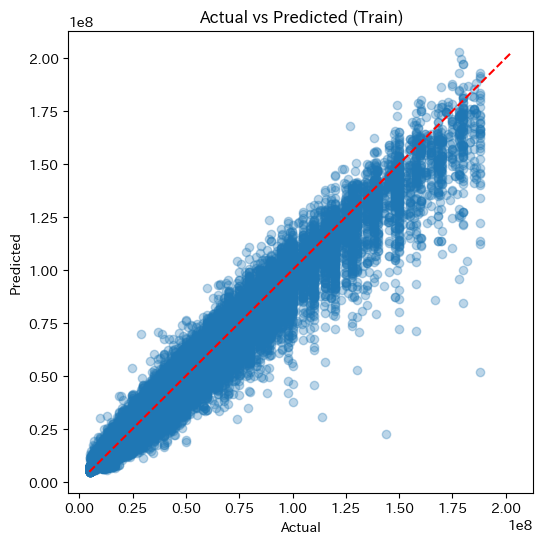

In [78]:
plt.figure(figsize=(6,6))
plt.scatter(train_df[target_col], y_pred_train, alpha=0.3)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted (Train)")

# 45度線（完璧な予測ライン）
min_val = min(train_df[target_col].min(), y_pred_train.min())
max_val = max(train_df[target_col].max(), y_pred_train.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.show()

## 特徴量重要度

In [74]:
base_fi = pd.DataFrame({
    "feature": fe_cols,
    "importance": base_model.feature_importances_
}).sort_values("importance", ascending=False)

low_fi = pd.DataFrame({
    "feature": fe_cols,
    "importance": low_model.feature_importances_
}).sort_values("importance", ascending=False)


In [75]:
base_fi.to_csv(f'{output_path}feature_importance_base.csv', index=False)
low_fi.to_csv(f'{output_path}feature_importance_low.csv', index=False)

#### 特徴量重要度=<2を削除

In [76]:
excluded_fe_base = base_fi.query("importance <= 2")["feature"].tolist()
print(excluded_fe_base)
print(len(excluded_fe_base))

base_cols = [c for c in fe_cols if c not in excluded_fe_base]
base_cat_cols = [c for c in cat_cols if c not in excluded_fe_base]

['専有部分設備_通信_CATV', 'sales_status_pca_1', 'building_type_missing', '建物構造・性能_バリアフリー', 'building_type', '専有部分設備_通信_インターネット対応', 'has_manager', 'management_form_score', 'genkyo_is_vacant', '建物構造・性能_耐震構造', '専有部分設備_浴室・洗面_共同バス', '建物構造・性能_吹き抜け', 'reform_wet_area 5', '用途・投資セグメント_不動産の証明書・性能評価_インスペクション（建物検査）報告書', 'reform_interior 6', 'reform_interior 3', 'usable_fixed_date_flag', '専有部分設備_空調・暖房_ガス暖房', 'ratio_mean_land_clip', 'bukken_type', '建物構造・性能_テラス', '建物設備（給排水・インフラ）_ガスその他', '建物設備（給排水・インフラ）_水道その他', '建物構造・性能_メゾネット', '専有部分設備_キッチン_コンロ四口以上', 'building_coverage_ratio', 'genkyo_is_land_only', 'contract_pca_1', '714101', '714003', '714002', '714001', '専有部分設備_通信_有線放送', 'contract_pca_2', '713903', '713902', '714102', '713901', '専有部分設備_収納_シューズクローク', '714103', '専有部分設備_通信_高速インターネット', '714201', '714202', '714203', '714301', 'contract_pca_3', '714303', '土地価格_低層住宅地', 'environment_pca_2', 'environment_pca_1', 'location_premium_pca_1', '土地価格_南道路', '土地価格_敷地延長・変形地', '714302', '295401', 'has_professional_management

In [77]:
excluded_fe_low = low_fi.query("importance <= 2")["feature"].tolist()
print(excluded_fe_low)
print(len(excluded_fe_low))

low_cols = [c for c in fe_cols if c not in excluded_fe_low]
low_cat_cols = [c for c in cat_cols if c not in excluded_fe_low]

['用途・投資セグメント_入居制限・利用制限_ペット不可', '建物構造・性能_耐震構造', '用途・投資セグメント_入居制限・利用制限_ペット可', '713903', 'has_management_association', '用途・投資セグメント_入居制限・利用制限_二人入居可', '専有部分設備_その他設備_家具・家電付', 'reform_interior 1', '建物構造・性能_デザイナーズ', 'genkyo_is_vacant', '建物設備（給排水・インフラ）_排水その他', '用途・投資セグメント_不動産の証明書・性能評価_空き家バンク登録物件', 'parking_keiyaku', '専有部分設備_浴室・洗面_浴室1.6×2.0M以上', 'tiny_area_flag_40', 'genkyo_is_land_only', '建物構造・性能_バリアフリー', 'reform_interior 6', '建物構造・性能_宅配ボックス', '714301', '714103', '714201', '714102', '714101', '用途・投資セグメント_契約・保証・法的ステータス関連_マンスリー可', '714202', '714003', '714203', '714002', 'environment_pca_1', '用途・投資セグメント_契約・保証・法的ステータス関連_自由設計対応', '用途・投資セグメント_契約・保証・法的ステータス関連_公庫利用可', '用途・投資セグメント_契約・保証・法的ステータス関連_家賃保証付き', '用途・投資セグメント_契約・保証・法的ステータス関連_手付金保証あり', 'location_premium_pca_1', '立地プレミアム_最寄り駅が始発駅', '立地プレミアム_複数路線', '土地価格_敷地延長・変形地', 'environment_pca_2', '714001', '土地価格_南道路', '土地価格_低層住宅地', '714303', '714302', '専有部分設備_トイレ_共同トイレ', 'has_kyoueki', '713902', '713901', 'land_expensive_flag', 'reform_exterior 1 ', 'reform_i

## 予測

In [81]:
# test データに対して最終予測
y_pred = predict_with_low_model(test_df, base_model, low_model, fe_cols, base_cols, low_cols)

# 必要に応じて安全クリップ（念のため）
# y_pred = np.clip(y_pred, 1e4, 3e8)

In [82]:
q = np.quantile(y_pred, [0, 0.25, 0.5, 0.75, 0.99, 1])
print("Min      :", q[0])
print("25% (Q1) :", q[1])
print("Median   :", q[2])
print("75% (Q3) :", q[3])
print("99%      :", q[4])
print("Max      :", q[5])

Min      : 4851599.405409964
25% (Q1) : 15060372.550620144
Median   : 23008193.466748707
75% (Q3) : 33767833.84642566
99%      : 97997907.78037217
Max      : 185441137.61512968


In [83]:
assert np.isfinite(y_pred).all(), "NaN/Inf detected in predictions!"
assert (y_pred > 0).all(), "Negative price detected!"

## 提出

In [84]:
submit_df = pd.read_csv(submit_file_path, header=None)
submit_df.columns = ['id', 'pred']

In [85]:
submit_df['pred'] = y_pred

In [86]:
submit_df.to_csv(
    f'{output_path}submit_20251206_v1.csv',
    index=False,
    header=False
)

## 追加するアクション一覧

- ☑️地価の追加
    - 最近傍ポイントでの地価
    - 最近傍3ポイントの距離重みづけ平均地価
    - 時系列変化
- ☑️学習データの追加
    - 時間がなくてとりあえず提案されたFEを追加しただけなので考察が必要
- ☑️非線形特徴量のログ化

今後
- 市区町村の人口密度
- 主要駅からの距離
- 主要都市までの距離
- リフォーム × 築年数 の交互作用FE生成コード
- 価格帯qcutカテゴリ特徴量の追加
- city ×（age, area, dist）交互作用の自動生成コード
- 建物タイプ別にサブモデルを作る

#### 振り返り
- ベースモデル：場所・規模・築年・周辺相場が主役
- 小規模モデル：それに加えて「部屋のスペック・設備」で細かく調整

価格帯別にMAE、MPE、MAPEを比較する

以下はあまりEDAに時間をかけられない日に試す
- ブレンドの重み・閾値の微調整
    - 低価格判定閾値：LOW_PRICE_TH → 閾値を 800万 / 1200万 に振る
    - low_model への寄せ方：w_low → w_low を 0.5 / 0.6 / 0.8 で試す

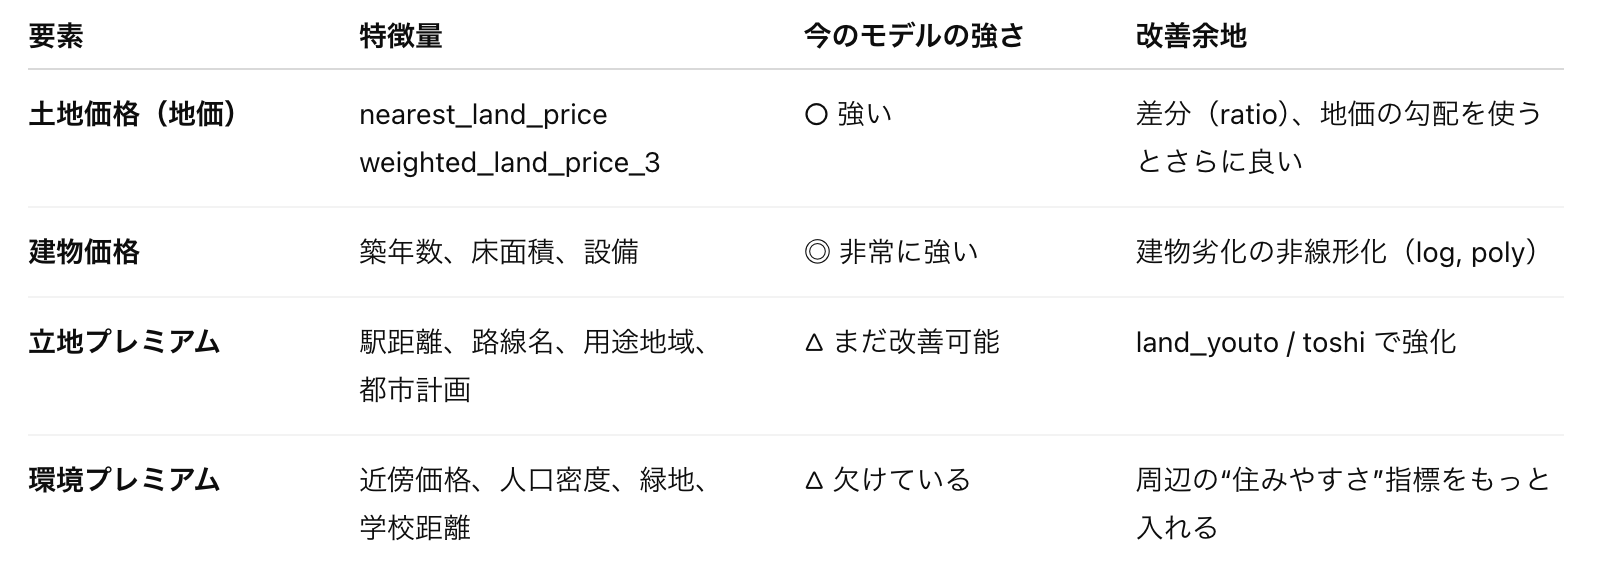

## 唐突なEDA

In [ ]:
train_df1 = pd.read_csv(train_file_path)
test_df1 = pd.read_csv(test_file_path)

#### データの鮮度

In [ ]:
train_df1[['building_type', 'bukken_type', 'flg_new', 'snapshot_modify_date', 'building_modify_date']]
# データの情報が違う可能性ある

,building_type,bukken_type,flg_new,snapshot_modify_date,building_modify_date
0,4,1202,0.0,2019-01-22 13:20:11,2019-01-24 00:10:08
1,4,1202,0.0,2019-01-30 15:15:49,2019-04-03 00:10:08
2,4,1202,0.0,2019-01-30 15:15:49,2020-06-06 00:10:11
3,4,1202,0.0,2019-01-30 21:54:10,2019-04-26 00:10:08
4,1,1302,0.0,2019-01-30 21:54:11,2025-09-15 02:49:23
...,...,...,...,...,...
363919,1,1302,0.0,2022-07-21 09:34:35,2025-10-04 00:45:08
363920,1,1302,0.0,2022-07-21 09:26:44,2025-09-21 00:45:08
363921,1,1302,0.0,2022-07-21 09:21:38,2025-09-16 00:45:08
363922,4,1202,0.0,2022-07-30 10:24:38,2023-10-23 09:49:37


In [ ]:
train_df1[['building_create_date', 'year_built']]
# データベースに反映された日だから意味ない（今のデータがいつのかは大事なのでmodifyは残すべき）

,building_create_date,year_built
0,2014-06-27 21:09:41,199204.0
1,2014-06-27 21:09:43,198108.0
2,2014-06-27 21:09:43,199506.0
3,2014-06-27 19:24:11,200203.0
4,2014-06-27 19:24:12,200703.0
...,...,...
363919,2014-06-27 21:09:33,198804.0
363920,2014-06-27 21:09:35,198205.0
363921,2014-06-27 21:09:35,198802.0
363922,2014-06-27 19:24:11,201711.0


#### 建物種別

In [ ]:
train_df1[['building_type', 'bukken_type', 'flg_new']].value_counts()

# 1, 1302, 0 →　中古マンション
# 4, 1202, 0 →　中古戸建
# 999, 1202, 0 →　中古戸建
# 999 ,1202, 1 →

building_type  bukken_type  flg_new
1              1302         0.0        194368
4              1202         0.0        152431
999            1202         0.0         10982
               1302         0.0          3284
4              1202         1.0          1018
5              1202         0.0           468
8              1302         0.0           322
15             1202         0.0           220
1              1302         1.0           207
9              1302         0.0           175
901            1302         0.0           123
15             1302         0.0            54
3              1202         0.0            42
999            1202         1.0            40
2              1302         0.0            36
8              1202         0.0            35
902            1202         0.0            23
9              1202         0.0            21
3              1302         0.0            19
902            1302         0.0            13
1              1202         0.0            1

#### 棟が存在しないってどういうことなんだろう

In [ ]:
test_df1[test_df1['building_status']==9][['building_create_date', 'building_modify_date']]

,building_create_date,building_modify_date
15,2014-06-27 19:24:21,2024-12-09 15:30:56
50,2014-06-27 21:12:26,2024-08-05 08:41:24
54,2014-06-27 21:12:29,2024-06-04 12:02:55
78,2014-06-27 21:12:39,2025-06-16 11:53:15
86,2014-06-27 21:12:46,2023-06-06 00:10:05
...,...,...
112183,2014-06-27 21:08:30,2025-06-16 11:49:48
112278,2014-06-27 21:08:44,2025-06-16 11:49:48
112332,2014-06-27 21:08:58,2025-06-16 11:49:48
112409,2014-06-27 21:09:13,2025-06-16 11:49:48


#### 木造で耐用年数22年超えている建物

In [ ]:
train_df[(train_df['building_structure']==1)&(train_df['year_built'] < 200001)][['money_room', 'year_built', 'full_address']].sort_values(by='year_built')

,money_room,year_built,full_address
144860,7800000,150001.0,京都府京都市西京区大原野外畑町250
195727,5900000,150001.0,京都府京都市西京区大原野外畑町250
282842,4900000,150001.0,京都府京都市西京区大原野外畑町250
240230,5400000,150001.0,京都府京都市西京区大原野外畑町250
136960,29800000,180001.0,京都府京都市中京区聚楽廻東町11-3
...,...,...,...
341706,11800000,199912.0,千葉県大網白里市上貝塚437-22
32101,23980000,199912.0,神奈川県横浜市栄区公田町931-405
288380,34980000,199912.0,大阪府大阪市住之江区西加賀屋3丁目10-18
94116,28800000,199912.0,千葉県柏市藤ケ谷新田93-13


In [ ]:
train_df[train_df['full_address'] == '京都府京都市西京区大原野外畑町250']

,target_ym,money_room,building_id,building_status,building_create_date,building_modify_date,building_type,building_name,building_name_ruby,homes_building_name,...,drugstore_distance,bank_distance,shopping_street_distance,est_other_name,est_other_distance,statuses,parking_keiyaku,money_hoshou_company,free_rent_duration,free_rent_gen_timing
144860,202007,7800000,176869,1,2014-06-27 22:38:16,2022-04-13 00:10:05,4,NaN,NaN,大原野外畑町,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195727,202101,5900000,176869,1,2014-06-27 22:38:16,2022-04-13 00:10:05,4,NaN,NaN,大原野外畑町,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240230,202107,5400000,176869,1,2014-06-27 22:38:16,2022-04-13 00:10:05,4,NaN,NaN,大原野外畑町,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
282842,202201,4900000,176869,1,2014-06-27 22:38:16,2022-04-13 00:10:05,4,NaN,NaN,大原野外畑町,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### memo
- trainとtestで同じ建物はある？
- 総階数が低いほど、土地価格の影響が大きくなる
- 地価の単位は円/1平方メートル→地価x土地面積とか良さそう？